# Computer Vision

## Task 1

Давай загрузим датасет CIFAR-10. Допиши функцию [load_dataloaders](./code-samples/cv_utils.py) с помощью [torchvision.datasets.CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)
и [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), чтобы функция возвращала
DataLoaderы для train и test частей датасета. \
C помощью функции `len` количество батчей в train_loader и test_loader.
> Для DataLoader параметры `transform` и `batch_size` оставьте по умолчанию.

In [4]:
#!pip install torch
#!pip install torchvision

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
BASE_TRANSFORM = transforms.Compose(
    [
        # Перевод изображений в тензоры
        transforms.ToTensor(),
        # Переводим цвета пикселей в отрезок [-1, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
BATCH_SIZE = 64 # Количество изображений в Батче
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Классы CIFAR10

In [3]:
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    # Дописанный фрагмент
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader

In [4]:
# Загрузка обучающего и тестового датасета
train_loader, test_loader = load_dataloaders()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
print(f'РЕШЕНИЕ:\n\
Количество батчей в train_loader:\t{len(train_loader)}\n\
Количество батчей в test_loader:\t{len(test_loader)}')

РЕШЕНИЕ:
Количество батчей в train_loader:	782
Количество батчей в test_loader:	157


## Task 2

Узнай, как из объекта DataLoader можно получить изображения и метки. \
Передай первые 4 изображения и метки из первого батча тестовой выборки в функцию [imshow](./code-samples/cv_utils.py).
С помощью нее можно визуализировать датасет. \
Должна получиться примерно такая визуализация.
![sample](../misc/images/images_sample.png)
> Картинки и метки могут отличаться. Главное чтобы метки сходились с изображениями)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [7]:
def imshow(images, labels, padding_size=15, labels_split_size=25):
    img = torchvision.utils.make_grid(images)
    # убрать нормализацию
    img = img / 2 + 0.5    
    npimg = img.numpy()
    label_text = (' ' * labels_split_size).join('{}'.format(CLASSES[j]) for j in labels.tolist())
    print(' ' * padding_size + label_text)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
# Загрузка картинок и меток из датасета
images, labels = next(iter(test_loader))

               cat                    ship                    ship                    plane


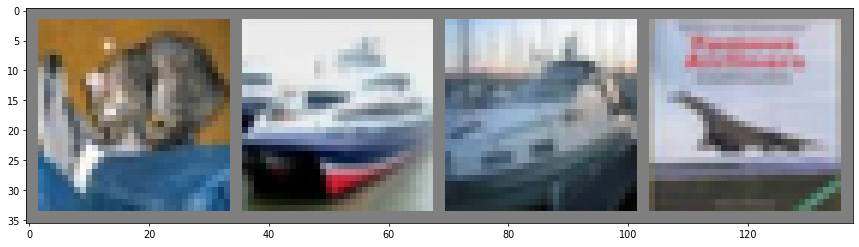

In [11]:
# Размер картинок
figure(figsize=(70, 4), dpi=70)
# Вывод картинок как в задании
imshow(images[:4], labels[:4], labels_split_size=22)

## Task 3

Теперь попробуем написать небольшую сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Напишем сеть, основанную на одном блоке архитектуры [ResNet](https://arxiv.org/pdf/1512.03385.pdf) - Residual-Block. Схема этого блока приведена ниже:

<img src="../misc/images/rediual_block.png" width="500"/>

Допишите класс ResidualNet:
- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Также в сверточных слоях `padding = 1`

Функции, которые вам понадобяться: 
[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

Для базовой проверки, что сеть написана верно этот код не должен выдавать ошибку\
`assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)`

In [12]:
import torch.nn as nn

In [14]:
class ResidualNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.conv_3 = nn.Conv2d(3, 32, 1)

        self.residual_block = nn.Sequential( 
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32)
        )

        self.clf = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(1),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):

        out = self.residual_block(x)
        out += self.conv_3(x)
        out = self.clf(out)

        return out

In [15]:
net = ResidualNet()
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

## Task 4

Перейдем к обучению сети. В этом вам поможет класс [Trainer](./code-samples/cv_utils.py).\
Для обучения кроме самой модели 
требуемся определить оптимизатор и функцию ошибок:
* В качестве оптимизатора выберите [стохастический градиентный спуск](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* В качестве функции ошибок
[кросс-энтропия](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Обучите сеть и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [16]:
class Trainer:
    
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        print('Сеть загружена на', self.device)
        
        self.optimizer = optimizer
        self.criterion = criterion

    def _train_epoch(self, train_loader):
        loss_log = []
        acc_log = []
        self.model.train()

        for data, target in train_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(data)

            loss = self.criterion(logits, target)
            loss.backward()
            self.optimizer.step()

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0]) 

        return np.mean(loss_log), np.mean(acc_log)

    def train(self, train_loader, test_loader, n_epochs):
        
        self.train_loss_log = [] 
        self.train_acc_log = [] 
        self.test_loss_log = []
        self.test_acc_log = []
        
        for epoch in range(n_epochs):
            train_loss, train_acc = self._train_epoch(train_loader)
            test_loss, test_acc = self.test(test_loader)

            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)

            self.test_loss_log.append(test_loss)
            self.test_acc_log.append(test_acc)

            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" test loss: {test_loss}, test acc: {test_acc}\n")
    
    def test(self, test_loader):
        loss_log = []
        acc_log = []
        self.model.eval()

        for data, target in test_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            with torch.no_grad():
                logits = self.model(data)
                loss = self.criterion(logits, target)

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0]) 

        return np.mean(loss_log), np.mean(acc_log)

In [17]:
def plot_train_log(trainer):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(trainer.train_loss_log) + 1), trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) + 1), trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(trainer.train_acc_log) + 1), trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) + 1), trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

In [18]:
import torch.optim as optim

# Оптимизатор
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.95)
# Функция ошибок (потерь)
criterion = nn.CrossEntropyLoss()

In [19]:
# Экземпляр класса Trainer()
trainer = Trainer(net, optimizer, criterion)
# Обучение
trainer.train(train_loader, test_loader, 5)

Сеть загружена на cpu
Epoch 0
 train loss: 97.15030945536425, train acc: 0.45810022378516624
 test loss: 109.61243006226364, test acc: 0.4479498407643312

Epoch 1
 train loss: 78.34228397452313, train acc: 0.5730298913043478
 test loss: 76.60967043250989, test acc: 0.5788216560509554

Epoch 2
 train loss: 71.78806706645605, train acc: 0.6108735613810742
 test loss: 76.6516863586037, test acc: 0.5866839171974523

Epoch 3
 train loss: 68.11419833224753, train acc: 0.6292559143222506
 test loss: 66.8222293671529, test acc: 0.6372412420382165

Epoch 4
 train loss: 66.41884380838145, train acc: 0.6388467071611253
 test loss: 67.63845232337903, test acc: 0.6312699044585988



In [20]:
# Функция отрисовки
def plot_train_log(trainer):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(trainer.train_loss_log) + 1), trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) + 1), trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')
    axs[1].plot(range(1, len(trainer.train_acc_log) + 1), trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) + 1), trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

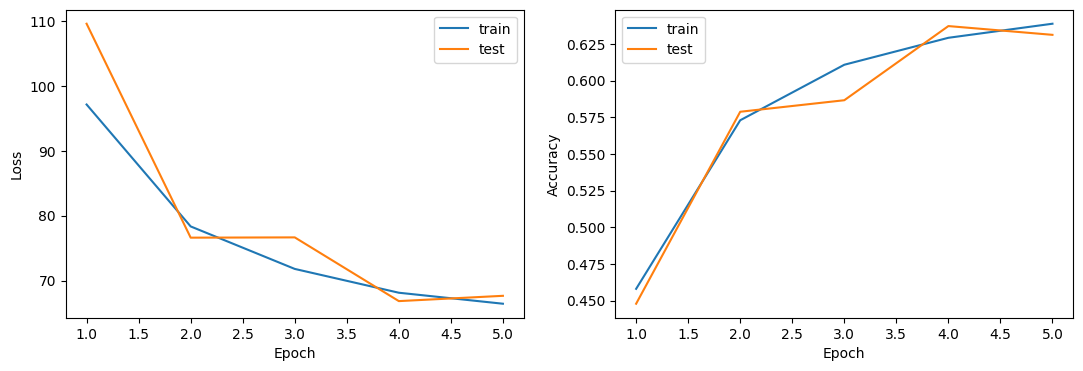

In [21]:
# Визуализации процесса обучения
plot_train_log(trainer)

## Task 5

Одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. \
Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки,  тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.
Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке `transforms`, который затем передается в Dataloader.\
Изучи, какие [способы аугментаций](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) 
изображений можно использовать PyTorch. Выберите несколько из них и визуализируйте как изменился датасет. 
![sample](../misc/images/images_sample.png)
![sample](../misc/images/augment.png)

Обучите сеть с аугментацией данных и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [22]:
transform_v2 = transforms.Compose(
        [
            transforms.RandomRotation(15),
            transforms.RandomHorizontalFlip(p=0.7),
            transforms.ColorJitter(brightness=0.22, contrast=0.25, saturation=0.27),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
)

train_loader_v2, test_loader_v2 = load_dataloaders(transform=transform_v2, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified


Первоначальный датасет
               cat                        ship                        ship                        plane


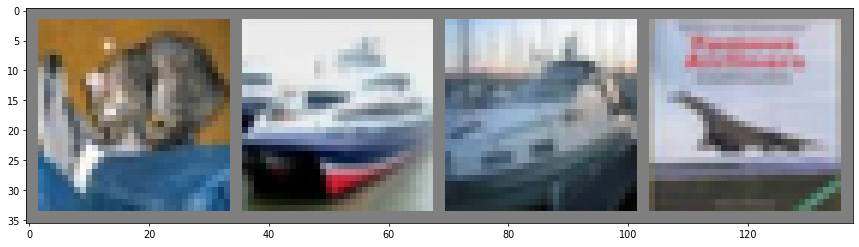

In [24]:
### Первоначальный датасет
# Загрузка картинок и меток из датасета начального
images, labels = next(iter(test_loader))
print('Первоначальный датасет')

# Размер картинок
figure(figsize=(70, 4), dpi=70)
# Вывод картинок как в задании
imshow(images[:4], labels[:4], labels_split_size=24)

Aугментированный датасет
               cat                        ship                        ship                        plane


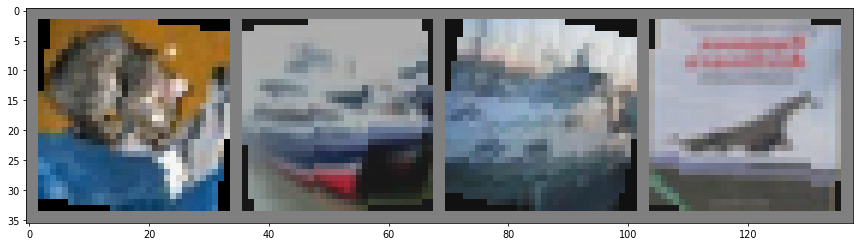

In [26]:
### Картинки аугментированного датасета
# Загрузка картинок и меток из датасета
images, labels = next(iter(test_loader_v2))

print('Aугментированный датасет')

# Размер картинок
figure(figsize=(70, 4), dpi=70)
# Вывод картинок как в задании
imshow(images[:4], labels[:4], labels_split_size=24)

In [27]:
# Экземпляр класса Trainer()
trainer_v2 = Trainer(net, optimizer, criterion)
# Обучение
trainer_v2.train(train_loader, test_loader, 5)

Сеть загружена на cpu
Epoch 0
 train loss: 65.99794545380965, train acc: 0.6420036764705882
 test loss: 67.63699393059797, test acc: 0.632265127388535

Epoch 1
 train loss: 63.90223904826757, train acc: 0.6533727621483376
 test loss: 66.67453267164291, test acc: 0.6376393312101911

Epoch 2
 train loss: 62.97724992966713, train acc: 0.6570692135549873
 test loss: 67.6996630954135, test acc: 0.6371417197452229

Epoch 3
 train loss: 62.04510882687386, train acc: 0.6625039961636828
 test loss: 64.79571333356724, test acc: 0.6403264331210191

Epoch 4
 train loss: 61.49121385340191, train acc: 0.665301310741688
 test loss: 65.9548063156711, test acc: 0.642515923566879



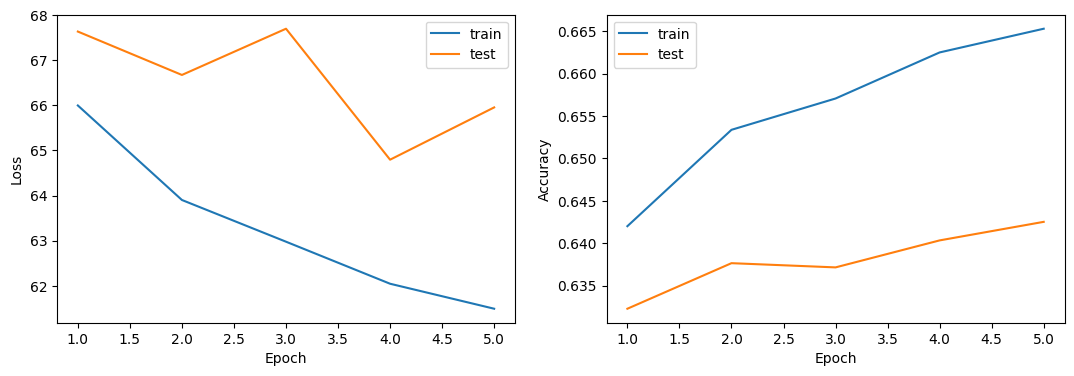

In [28]:
# Визуализации процесса обучения
plot_train_log(trainer_v2)